In [19]:
from warnings import filterwarnings
from json import dump
from math import log10, floor, ceil

import matplotlib.pyplot as plt
from optuna import load_study
from optuna.exceptions import ExperimentalWarning

# from optuna.visualization import plot_pareto_front, plot_slice
from optuna.visualization.matplotlib import plot_pareto_front, plot_slice
from optuna.trial import TrialState
from pandas import DataFrame, set_option

filterwarnings("ignore", category=ExperimentalWarning)

In [2]:
def get_study(study_name, folder="."):
    db_name = f"{folder}/{study_name}.db"
    storage_name = f"sqlite:///{db_name}"
    study = load_study(study_name=study_name, storage=storage_name)
    print(study.study_name, "loaded.")
    return study

In [3]:
study_1 = get_study("HP-optimization-01", folder="hp1")
study_2 = get_study("HP-optimization-02", folder="hp2")

HP-optimization-01 loaded.
HP-optimization-02 loaded.


# Influence of the HPs

In [8]:
min_mse_scale, max_mse_scale = 1e-2, 1e1

(0.01, 10.0)

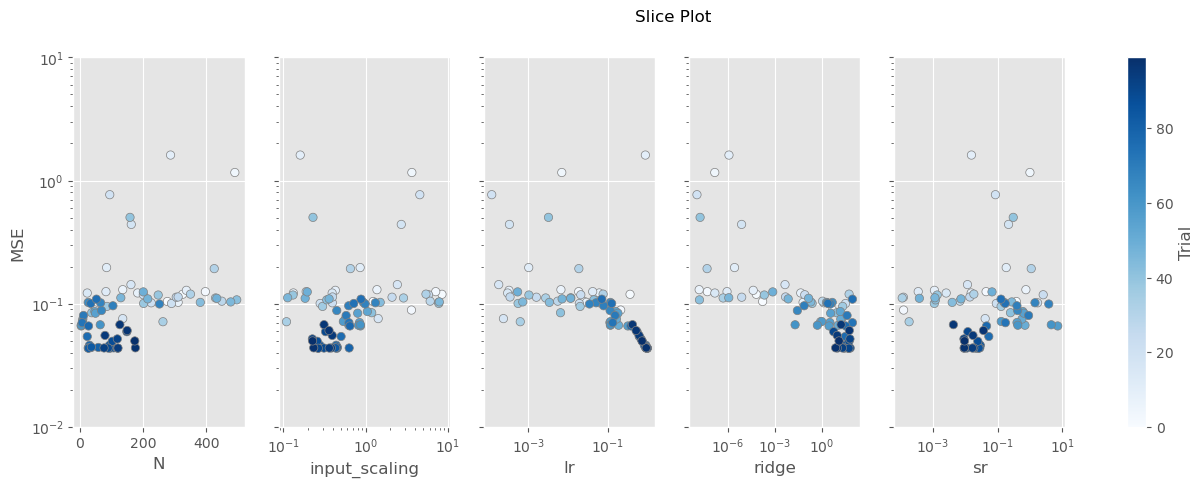

In [9]:
axes = plot_slice(
    study_1,
    params=["N", "sr", "lr", "ridge", "input_scaling"],
    target=lambda t: t.values[0],
    target_name="MSE",
)
ax = axes[0]
ax.set_yscale("log")
ax.set_ylim(bottom=min_mse_scale, top=max_mse_scale)

(0.01, 10.0)

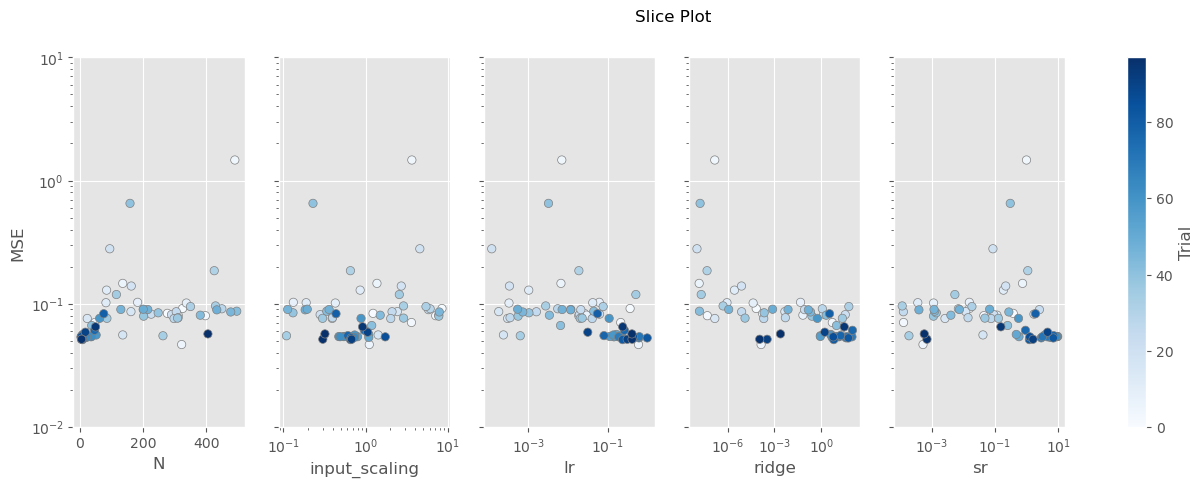

In [10]:
axes = plot_slice(
    study_2,
    params=["N", "sr", "lr", "ridge", "input_scaling"],
    target=lambda t: t.values[0],
    target_name="MSE",
)
ax = axes[0]
ax.set_yscale("log")
ax.set_ylim(bottom=min_mse_scale, top=max_mse_scale)

# Best trials

In [35]:
study = study_1
DataFrame(
    [
        {
            "trial_num": t.number,
            "MSE": t.values[0],
            "N": t.params["N"],
        }  # , "N": int(t.values[1])}
        for t in study.trials
        if t.state is TrialState.COMPLETE
    ]
).set_index("trial_num").sort_values("MSE")

,MSE,N
trial_num,,
82,0.043,28
91,0.044,120
87,0.044,96
89,0.044,90
94,0.044,121
...,...,...
4,1.2,490
10,1.6,287
13,1.2e+03,187


In [28]:
best_params_1 = [
    study_1.trials[82].params,
]

In [29]:
study = study_2
DataFrame(
    [
        {
            "trial_num": t.number,
            "MSE": t.values[0],
            "N": t.params["N"],
        }  # , "N": int(t.values[1])}
        for t in study.trials
        if t.state is TrialState.COMPLETE
    ]
).set_index("trial_num").sort_values("MSE")

,MSE,N
trial_num,,
98,0.040,29
99,0.041,29
5,0.047,322
81,0.051,9
91,0.051,6
...,...,...
19,0.28,95
40,0.65,159
4,1.5,490


In [30]:
best_params_2 = [
    study_2.trials[98].params,
    study_2.trials[99].params,
]

Comparison between the best params of both optimizations.

In [31]:
set_option("display.float_format", "{:#.2g}".format)
df_best = DataFrame(best_params_1 + best_params_2)
df_best

,N,sr,lr,input_scaling,ridge
0,28,0.022,1.0,0.45,51.
1,29,0.00064,0.74,0.26,0.00011
2,29,0.00054,0.72,0.27,3.6e-05


In [32]:
dict_params = df_best.median().to_dict()
dict_params

{'N': 29.0,
 'sr': 0.0006408445756693926,
 'lr': 0.7435919182332743,
 'input_scaling': 0.2660558620192844,
 'ridge': 0.00011126592946588929}

In [33]:
dict_params["N"] = int(dict_params["N"])

In [34]:
with open("HP_medians.json", "w") as j:
    dump(dict_params, j)